In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data_dir = "data/"

In [3]:
ftrain = []
ytrain = []
for i in range(40):
    for j in range(6):
        ftrain.append(os.path.join(data_dir, str(i+1)+"_"+str(j+1)+".png"))
        ytrain.append(i)
print("number of training images:",len(ftrain))

original_shape = cv2.imread(ftrain[0],0).shape
print("original shape:",original_shape)

xtrain = []
for fn in ftrain:
    tmp = cv2.imread(fn,0)
    tmp = tmp.reshape(-1)
    xtrain.append(tmp)
xtrain = np.array(xtrain)
ytrain = np.array(ytrain)
print("training dataset for PCA, its shape =",xtrain.shape)

number of training images: 240
original shape: (56, 46)
training dataset for PCA, its shape = (240, 2576)


## (a.1) mean face

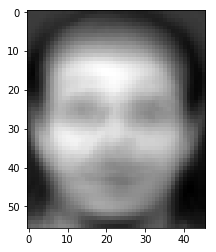

In [4]:
mean_face = np.mean(xtrain,axis=0)
mean_face = np.reshape(mean_face,newshape=original_shape)
plt.imshow(mean_face, cmap='gray')

## (a.2) the first three eigenfaces  

In [5]:
pca = PCA(n_components=min(xtrain.shape)-1)
e = pca.fit(xtrain-mean_face.reshape(-1))

In [6]:
pc1 = np.reshape(e.components_[0],newshape=original_shape)
pc2 = np.reshape(e.components_[1],newshape=original_shape)
pc3 = np.reshape(e.components_[2],newshape=original_shape)

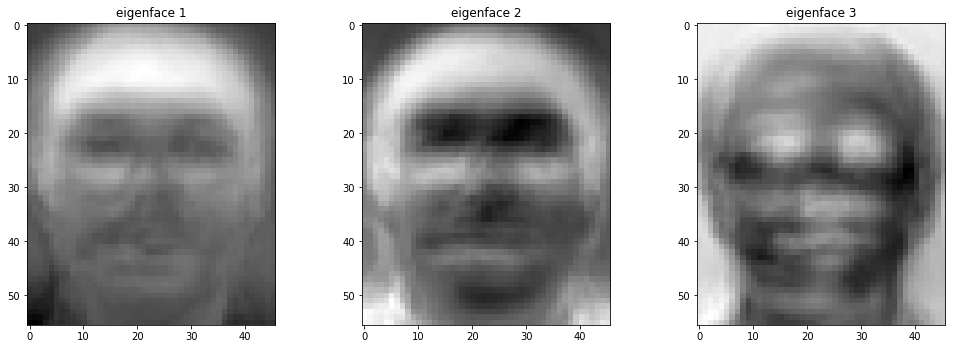

In [7]:
plt.figure(figsize=(15,16))
plt.subplot(131)
plt.imshow(pc1,cmap='gray')
plt.title("eigenface 1")
plt.subplot(132)
plt.imshow(pc2,cmap='gray')
plt.title("eigenface 2")
plt.subplot(133)
plt.imshow(pc3,cmap='gray')
plt.title("eigenface 3")
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)
plt.show()
plt.close()

# (b) 

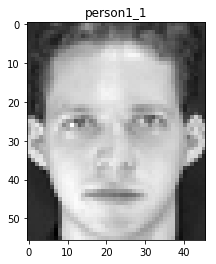

In [8]:
target = cv2.imread("data/1_1.png",0)
plt.title("person1_1")
plt.imshow(target, cmap="gray")

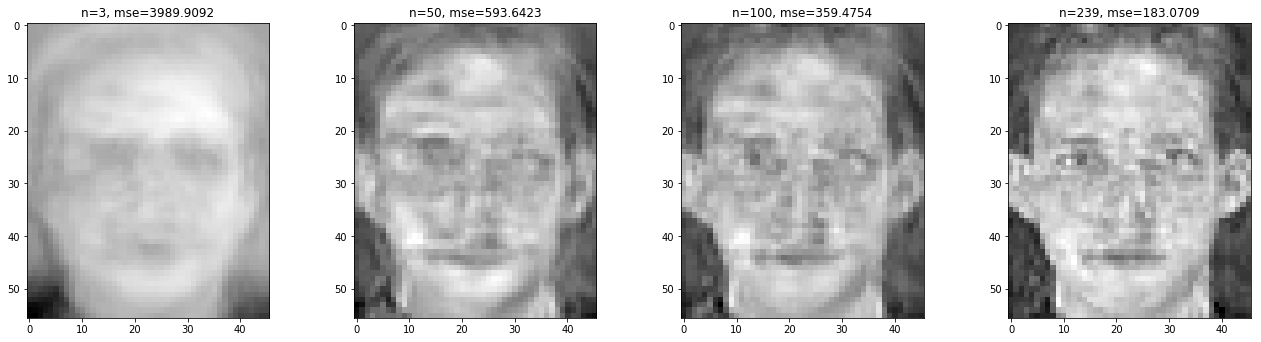

In [9]:
target = np.reshape(target,newshape=(1,-1))
e_target = e.transform(target)

plt.figure(figsize=(20,16))
n = [3,50,100,239]
for k in range(len(n)):
    tmp = np.dot(e_target[0,:n[k]], e.components_[:n[k],:])
    mse = np.mean((tmp - target)**2)
    tmp = np.reshape(tmp, newshape=original_shape)
    plt.subplot(1,4,k+1)
    plt.title("n=%s, mse=%.4f" % (n[k], mse))
    plt.imshow(tmp, cmap='gray')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.1, right=0.95, hspace=0.25,wspace=0.35)

# (c) 

In [10]:
ptrain = e.transform(xtrain)

In [11]:
params = {'n_neighbors':[1,3,5]}
kNN = KNeighborsClassifier()
clf = GridSearchCV(kNN, params,cv=3)

In [12]:
n = [3, 50, 159]
res = dict()
for k in n:
    clf.fit(ptrain[:,:k], ytrain)
    res['n='+str(k)] = np.array(clf.cv_results_['mean_test_score'])

In [13]:
res = pd.DataFrame.from_dict(res,orient='index')
res.columns = ['k=1','k=3','k=5']
print(res)

            k=1       k=3       k=5
n=3    0.708333  0.587500  0.487500
n=50   0.929167  0.875000  0.775000
n=159  0.925000  0.870833  0.745833


### Best choice: k=1, n=50

In [14]:
k, n = 1, 50

In [15]:
# get testing filenames and labels
ftest = []
ytest = []
for i in range(40):
    for j in range(6,10):
        ftest.append(os.path.join(data_dir, str(i+1)+"_"+str(j+1)+".png"))
        ytest.append(i)
print("number of test images:",len(ftest))

# read testing images
xtest = []
for fn in ftest:
    tmp = cv2.imread(fn,0)
    tmp = tmp.reshape(-1)
    xtest.append(tmp)
xtest = np.array(xtest)
ytest = np.array(ytest)
print("testing dataset, its shape =",xtest.shape)

# Project images onto the principal components
ptest = e.transform(xtest)
print("projected testing dataset, its shape=", ptest.shape)

number of test images: 160
testing dataset, its shape = (160, 2576)
projected testing dataset, its shape= (160, 239)


In [16]:
# kNN model with optimized hyper-parameter (k,n)
bestkNN = KNeighborsClassifier(n_neighbors=k)
bestkNN.fit(ptrain[:,:n], ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [17]:
ypred = bestkNN.predict(ptest[:,:50])
print("overall accuracy:",accuracy_score(y_pred=ypred, y_true=ytest))

overall accuracy: 0.9625
